## Advanced use of RNN

There are 3 advances techniques for improving the performance and generalization power of RNNs. 

- Recurrent dropout
- Stacking recurrent layers
- Bidirectional recurrent layers

### A temperature forecasting problem

In [1]:
import os
data_dir = r'./jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


We have 420551 lines of data. We should convert them to numpy arrays so we can work with them.

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Now we have a numpy array (matrix) organizes as `lines x values`  
We can plot the temperature:

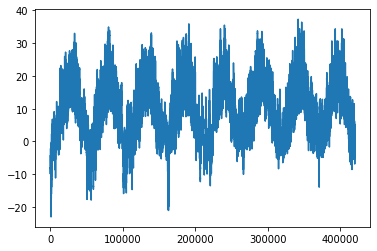

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

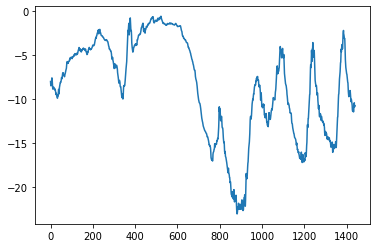

In [4]:
# as each datapoint was collected every 10 minutes, 
# we can plot the temp data of the first 10 days of the recorded data

plt.plot(range(1440), temp[:1440])

We can clearly see the yearly periodicity of the temp, which is not there if we have a look at a few days timespan. 

We want to predict the temperature 24 hours in the future for a given time window, let's try that with NNs. 

### Preparing the data

First, we normalize the data, only using the first 200000 timestamps as training data. 

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now we create a generator that returns the timeseries samples and an array of targets temperatures

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''
    - data : The original array of floating-point data, which you normalized in listing 6.32.
    - lookback : How many timesteps back the input data should go.
    - delay : How many timesteps in the future the target should be.
    - min_index and max_index : Indices in the data array that delimit which timesteps to draw from. 
                                This is useful for keeping a segment of the data for validation and 
                                another for testing.
    - shuffle : Whether to shuffle the samples or draw them in chronological order.
    - batch_size : The number of samples per batch.
    - step : The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw 
            one data point every hour.
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), 
                            lookback // step, 
                            data.shape[-1]))
        
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

We will use the generator function to instantiate 3 generators: one for training, one for validation, and one for testing. Each one will take different temporal segments of the data. 

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)

test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [12]:
val_steps

769

In order to have a baseline method to which our network method is compared, we create a naive method that predicts the temperature 24 hours from now to be exactly the same as right now. We evaluate this method with the mean absolute error (MAE):

In [13]:
def evaluate_naive_method():
    batch_maes = [] 
    for step in range(val_steps): # it takes too long with val_steps
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets)) 
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [15]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


We have an average absolute error of about `2.57ºC` as baseline

### A basic Machine-learning approach

Before using RNN, let's use Dense layers

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import time

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, 
                                      float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

start = time.perf_counter()

history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/20
500/500 [==============================] - 17s 35ms/step - loss: 1.3130 - val_loss: 0.6206
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3925 - val_loss: 0.3608
Epoch 3/20
500/500 [==============================] - 19s 37ms/step - loss: 0.2831 - val_loss: 0.3481
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2629 - val_loss: 0.2988
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2523 - val_loss: 0.3622
Epoch 6/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2430 - val_loss: 0.3281
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2368 - val_loss: 0.3095
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2320 - val_loss: 0.3502
Epoch 9/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2255 - val_loss: 0.3195
Epoch 10/20
500/500 [==============================] - 18s 36ms/step - loss: 0.223

GPU time: 351.782 seconds -> 5.86 minutes

Now we plot the loss curves:

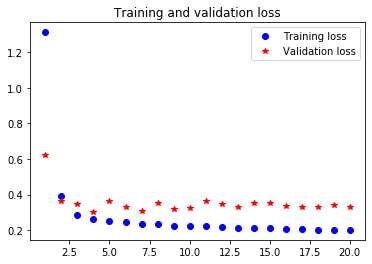

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We can compare the validation loss from this plot to the MAE value obtained from the baseline calculation (~0.29). We are at about the same value using this simple neural network. Our informed assumption is very powerful in comparison to this simple machine learning approach. 

### First recurrent baseline

Now, by using an RNN we will be reading the data as a sequence, which is perfect for this kind of data. 

We'll be using the Gate Recurrent Unit ([GRU](https://arxiv.org/abs/1412.3555)) layer, which follows the same principle as LSTM but it's cheaper to run. 

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import time

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

start = time.perf_counter()

history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/20
500/500 [==============================] - 358s 715ms/step - loss: 0.3018 - val_loss: 0.2724
Epoch 2/20
500/500 [==============================] - 355s 711ms/step - loss: 0.2873 - val_loss: 0.2711
Epoch 3/20
500/500 [==============================] - 345s 689ms/step - loss: 0.2795 - val_loss: 0.2630
Epoch 4/20
500/500 [==============================] - 360s 720ms/step - loss: 0.2745 - val_loss: 0.2670
Epoch 5/20
500/500 [==============================] - 317s 634ms/step - loss: 0.2675 - val_loss: 0.2619
Epoch 6/20
500/500 [==============================] - 317s 634ms/step - loss: 0.2639 - val_loss: 0.2673
Epoch 7/20
500/500 [==============================] - 319s 638ms/step - loss: 0.2578 - val_loss: 0.2649
Epoch 8/20
500/500 [==============================] - 304s 608ms/step - loss: 0.2533 - val_loss: 0.2680
Epoch 9/20
500/500 [==============================] - 304s 608ms/step - loss: 0.2490 - val_loss: 0.2672
Epoch 10/20
500/500 [==============================] - 302s 604m

Local GPU time: 6552.676 seconds -> 1.8 hrs!

In [21]:
from keras import models

models.save_model(model, 'first_rnn_jena_climate.h5')

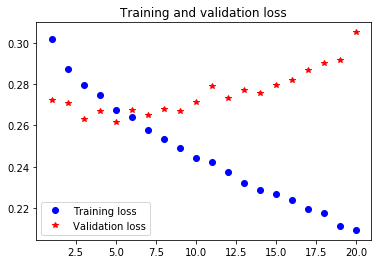

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Here we can see that the validation loss reached a lower value than the baseline. 

In [27]:
min(val_loss)

0.2619032590360573

In [36]:
celsius_mae_simple_rnn = min(val_loss) * std[1]
print('Mean absolute error = {:.3}ºC'.format(celsius_mae_simple_rnn))

Mean absolute error = 2.32ºC


We have a MAE of about `2.32ºC`, better than the baseline of `2.57ºC`.

### Using recurrent dropout to fight overfitting

In the case of recurrent layers, there is another type of dropout usage, the recurrent dropout, that applies the same dropout to the recurrent activation of the layer. This method is the best for RNN according to this [thesis](http://mlg.eng.cam.ac.uk/yarin/blog_2248.html). 

In [39]:
from keras.models import Sequential
from keras  import layers
from keras.optimizers import RMSprop
import time 

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2, 
                     recurrent_dropout=0.2, 
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

start = time.perf_counter()

history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=40, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/40
500/500 [==============================] - 399s 799ms/step - loss: 0.3365 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 429s 857ms/step - loss: 0.3146 - val_loss: 0.2730
Epoch 3/40
500/500 [==============================] - 397s 794ms/step - loss: 0.3078 - val_loss: 0.2691
Epoch 4/40
 96/500 [====>.........................] - ETA: 3:58 - loss: 0.3096

KeyboardInterrupt: 